In [1]:
import pandas as pd
import imageio
import glob
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
from copy import deepcopy
import json
import numpy as np
from skimage.transform import resize

#### 1. Reading Mask data

In [2]:
mask_dir_path = '../../gtFine/train/'
mask_files = [f for f in glob.glob(mask_dir_path + "**/*color.png", recursive=True)]
print("number of mask file :::",len(mask_files))

number of mask file ::: 2975


#### 2. Preparing dataframe with path of train image, mask 

In [3]:
def prepare_id(file_path):
    # Extract the filename
    filename = os.path.basename(file_path)
    # Remove the suffix '_gtFine_color.png' from the filename
    extracted_part = filename.replace('_gtFine_color.png', '')
    return extracted_part

def city_folder(x):
    x = x.split("_")[0]
    return x

def mask_json_file_path(image_path):
    image_path = "../../gtFine/train/" + image_path + "_gtFine_polygons.json"
    return image_path

def train_image_path(image_path):
    image_path = "../../data/leftImg8bit/train/" + image_path + "_leftImg8bit.png"
    return image_path

def images_to_numpy_array(images):
    return np.array(images)

def get_vegetation_mask(image, data):
    for i in data["objects"]:
        if(i['label']=='vegetation'):
            points = np.array(i["polygon"], np.int32)
            points = points.reshape((-1, 1, 2))
            image = cv2.fillPoly(image, [points], (255, 255, 255))
        else:
            points = np.array(i["polygon"], np.int32)
            points = points.reshape((-1, 1, 2))
            image = cv2.fillPoly(image, [points], (0, 0, 0))
    image[image!=255]=0
    return image

df = pd.DataFrame()
df["mask_file"] = mask_files
df["id"] = df.mask_file.map(lambda x: prepare_id(x))
df["city_name"] = df.id.map(lambda x: city_folder(x))
df["file_path_suffix"] = df["city_name"] + "/" + df["id"]
df["mask_json_file_path"] = df.file_path_suffix.map(lambda x: mask_json_file_path(x))
df["test_image_path"] = df.file_path_suffix.map(lambda x: train_image_path(x))
df.head()

,mask_file,id,city_name,file_path_suffix,mask_json_file_path,test_image_path
0,../../gtFine/train/aachen/aachen_000089_000019...,aachen_000089_000019,aachen,aachen/aachen_000089_000019,../../gtFine/train/aachen/aachen_000089_000019...,../../data/leftImg8bit/train/aachen/aachen_000...
1,../../gtFine/train/aachen/aachen_000028_000019...,aachen_000028_000019,aachen,aachen/aachen_000028_000019,../../gtFine/train/aachen/aachen_000028_000019...,../../data/leftImg8bit/train/aachen/aachen_000...
2,../../gtFine/train/aachen/aachen_000112_000019...,aachen_000112_000019,aachen,aachen/aachen_000112_000019,../../gtFine/train/aachen/aachen_000112_000019...,../../data/leftImg8bit/train/aachen/aachen_000...
3,../../gtFine/train/aachen/aachen_000165_000019...,aachen_000165_000019,aachen,aachen/aachen_000165_000019,../../gtFine/train/aachen/aachen_000165_000019...,../../data/leftImg8bit/train/aachen/aachen_000...
4,../../gtFine/train/aachen/aachen_000055_000019...,aachen_000055_000019,aachen,aachen/aachen_000055_000019,../../gtFine/train/aachen/aachen_000055_000019...,../../data/leftImg8bit/train/aachen/aachen_000...


#### Reading and saving the mask image

In [ ]:
train_mask_img = []
for mask_image_path in mask_files:
    mask_arr=imageio.imread(mask_image_path)
    img=cv2.cvtColor(mask_arr,cv2.COLOR_BGR2GRAY)
    train_mask_img.append(img)
    
train_mask_img = images_to_numpy_array(train_mask_img)
np.save('../../numpy_arr_data/test_mask_gray_img.npy', train_mask_img)

/var/tmp/ipykernel_118618/1055716132.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_arr=imageio.imread(mask_image_path)


In [19]:
train_mask_img.shape

(500, 1024, 2048)

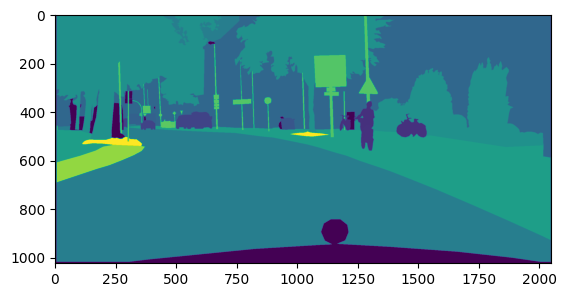

In [20]:
plt.imshow(train_mask_img[3])

In [21]:
train_mask_json = []
# Open and read the JSON file
for mask_json in df.mask_json_file_path.values:
    with open(mask_json, 'r') as file:
        train_mask_json.append(json.load(file))

#### Creating and extracting vegetaion mask

In [22]:
train_mask_img = np.load("../../numpy_arr_data/test_mask_gray_img.npy")
vegetation_mask_img = []
for img, json_data in zip(train_mask_img, train_mask_json):
    img = get_vegetation_mask(img, json_data)
    vegetation_mask_img.append(img)
    
vegetation_mask_img = images_to_numpy_array(vegetation_mask_img)
np.save('../../numpy_arr_data/test_veg_mask_gray_img.npy', vegetation_mask_img)

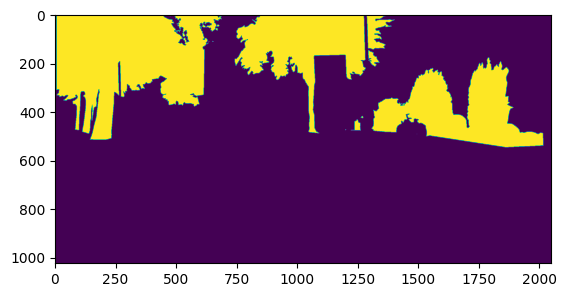

In [23]:
plt.imshow(vegetation_mask_img[3])

#### Creating train image

In [17]:
train_img = []
for train_img_path in df.test_image_path.values:
    train_arr=imageio.imread(train_img_path)
    img=cv2.cvtColor(train_arr, cv2.COLOR_BGR2RGB)
    train_img.append(img)
    
train_img = images_to_numpy_array(train_img)
np.save('../../numpy_arr_data/test_img.npy', train_img)

/var/tmp/ipykernel_12153/111885085.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_arr=imageio.imread(train_img_path)


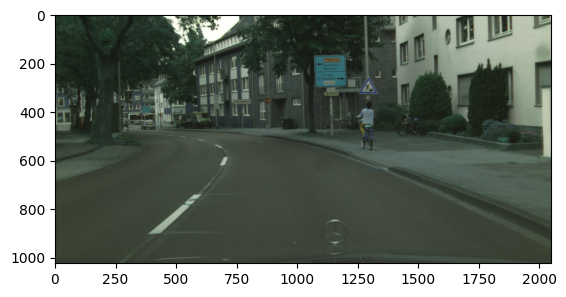

In [22]:
plt.imshow(train_img[3])

#### 3. Resizing image and mask

In [25]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor

2024-08-04 22:27:50.613273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 22:27:52.985566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-08-04 22:27:52.985751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PA

In [14]:
train_img = np.load("../../numpy_arr_data/test_img.npy")

In [24]:
def image_preprocessing(image):
    """
    This function reads a numpy array of 
    images and return the contents as a 
    numpy array.
    """
    image= image.astype('float32')
    image= image - np.mean(image)
    image = image / np.std(image)
    # image = image[...,np.newaxis]
    image = resize(image,(512,512),preserve_range=True)
    return image


In [25]:
def batch_preprocess_images(train_img):
    with ThreadPoolExecutor() as executor:
        preprocessed_images = list(executor.map(image_preprocessing, train_img))
    return np.array(preprocessed_images)

train_img = batch_preprocess_images(train_img)

In [26]:
train_img.shape

(500, 512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


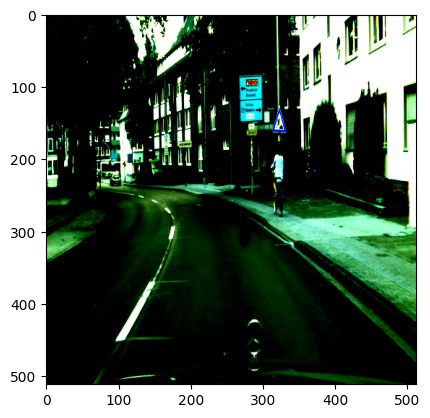

In [28]:
plt.imshow(train_img[3])

In [27]:
np.save('../../numpy_arr_data/test_img.npy', train_img)

In [26]:
def mask_preprocessing(mask):
    """
    This function reads a numpy array of 
    images and return the contents as a 
    numpy array.
    """
    mask = mask/255
    # mask=mask[...,np.newaxis]
    mask = resize(mask,(512,512),preserve_range=True)
    return mask

def batch_preprocess_mask(vegetation_mask_img):
    with ThreadPoolExecutor() as executor:
        preprocessed_images = list(executor.map(mask_preprocessing, vegetation_mask_img))
    return np.array(preprocessed_images)

vegetation_mask_img = np.load("../../numpy_arr_data/test_veg_mask_gray_img.npy")
vegetation_mask_img = batch_preprocess_mask(vegetation_mask_img)
np.save('../../numpy_arr_data/test_vegetation_mask_gray_img.npy', vegetation_mask_img)

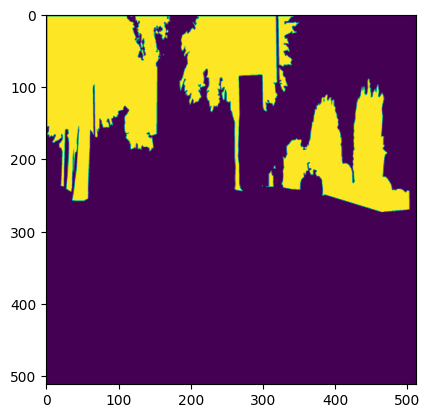

In [27]:
plt.imshow(vegetation_mask_img[3])

In [6]:
ve

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


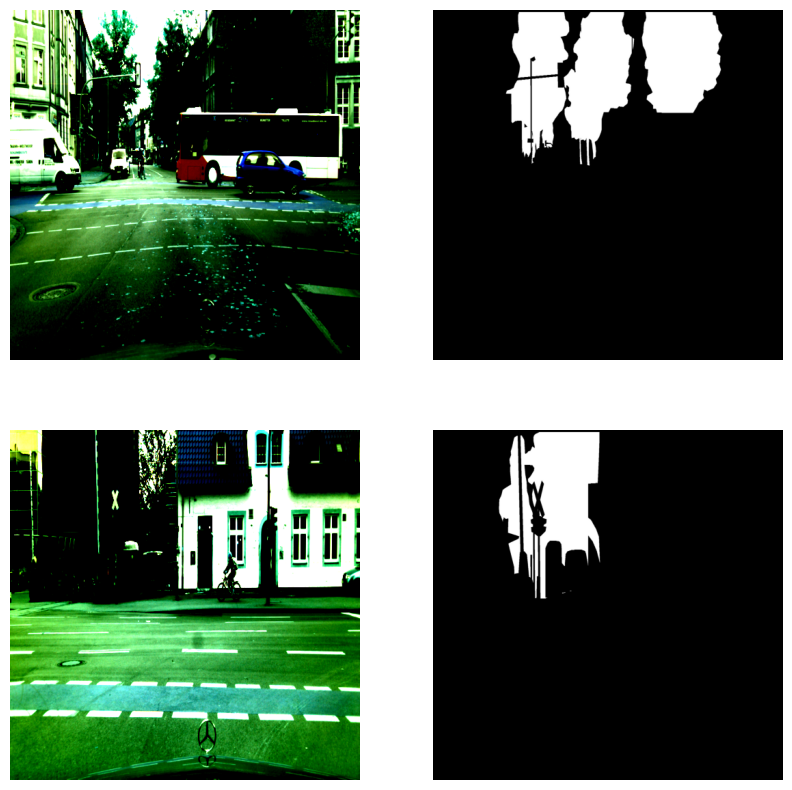

In [33]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [train_img[2], vegetation_mask_img[2], train_img[4], vegetation_mask_img[4]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()
